# Clustering Mobil: K-Means dengan PCA Feature Selection
**Alur Pengerjaan:**
1. Data Cleaning & Parsing (Unit Removal)
2. Z-Score Scaling (Standarisasi Data)
3. Feature Selection dengan PCA (Eliminasi fitur yang tidak berkontribusi)
4. Reduksi Dimensi (PCA Final)
5. Penentuan K Optimal (Elbow Method Otomatis)
6. K-Means Clustering
7. Profiling & Segmentasi User

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings

# Abaikan warning minor agar output bersih
warnings.filterwarnings('ignore')

# Konfigurasi Tampilan
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Buat folder output
if not os.path.exists('Hasil'):
    os.makedirs('Hasil')

# Load Dataset
file_path = 'Dataset/CarsDataset2025.csv' # Pastikan path sesuai dengan lokasi file Anda

try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil diload.")
    print(f"   Dimensi: {df.shape[0]} Baris, {df.shape[1]} Kolom")
    display(df.head(3))
except FileNotFoundError:
    print(f"File tidak ditemukan di: {file_path}")

Dataset berhasil diload.
   Dimensi: 1218 Baris, 11 Kolom


,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm


In [2]:
# --- 1. DEFINISI FUNGSI CLEANING ---
def clean_currency(value):
    """Membersihkan format mata uang ($, koma) dan menangani range harga."""
    if pd.isna(value): return np.nan
    val_str = str(value).replace('$', '').replace(',', '').replace(' ', '')
    
    # Handle range (misal: "10000-20000") -> ambil rata-rata
    if '-' in val_str:
        try:
            low, high = val_str.split('-')
            return (float(low) + float(high)) / 2
        except: return np.nan
    
    try: return float(val_str)
    except: return np.nan

def clean_unit(value):
    """Menghapus satuan (hp, km/h, sec) dan mengambil angka."""
    if pd.isna(value): return np.nan
    val_str = str(value).lower()
    
    # Hapus satuan umum
    for unit in ['cc', 'hp', 'km/h', 'sec', 'nm', 'seconds']:
        val_str = val_str.replace(unit, '')
    
    # Handle kasus "4.0/5.0" (ambil nilai pertama)
    if '/' in val_str: val_str = val_str.split('/')[0]
    
    val_str = val_str.replace(',', '').strip()
    
    # Handle range dengan regex
    if '-' in val_str:
        try:
            parts = re.findall(r"[\d\.]+", val_str)
            nums = [float(p) for p in parts]
            return sum(nums) / len(nums) if nums else np.nan
        except: return np.nan
        
    # Ambil angka pertama yang ditemukan
    match = re.search(r"[\d\.]+", val_str)
    if match: return float(match.group())
    return np.nan

# --- 2. TERAPKAN CLEANING ---
df_clean = df.copy()

# Daftar kolom yang akan dibersihkan
cols_to_clean = {
    'Cars Prices': clean_currency,
    'CC/Battery Capacity': clean_unit,
    'HorsePower': clean_unit,
    'Total Speed': clean_unit,
    'Performance(0 - 100 )KM/H': clean_unit,
    'Torque': clean_unit
}

for col, func in cols_to_clean.items():
    df_clean[col] = df_clean[col].apply(func)

# Khusus Seats (pastikan numerik)
df_clean['Seats'] = pd.to_numeric(df_clean['Seats'], errors='coerce')

# --- 3. FILL MISSING VALUES ---
# Atribut numerik inti yang akan digunakan untuk analisis
initial_numeric_cols = [
    'CC/Battery Capacity', 'HorsePower', 'Total Speed', 
    'Performance(0 - 100 )KM/H', 'Cars Prices', 'Torque', 'Seats'
]

# Isi NaN dengan Median (lebih aman daripada Mean untuk outlier)
for col in initial_numeric_cols:
    median_val = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_val)

print("Data Cleaning Selesai.")
print("   Sample data bersih:")
display(df_clean[initial_numeric_cols].head())

Data Cleaning Selesai.
   Sample data bersih:


,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Torque,Seats
0,3990.0,963.0,340.0,2.5,1100000.0,800.0,2.0
1,6749.0,563.0,250.0,5.3,460000.0,900.0,5.0
2,1200.0,77.5,165.0,10.5,13500.0,120.0,5.0
3,3982.0,630.0,250.0,3.2,161000.0,900.0,4.0
4,5204.0,602.0,320.0,3.6,253290.0,560.0,2.0


In [4]:
from sklearn.preprocessing import StandardScaler

# --- Z-SCORE SCALING (STANDARDIZATION) ---
# Penting dilakukan SEBELUM PCA agar satuan (misal Harga vs Detik) setara.

print(" Melakukan Scaling pada atribut:", initial_numeric_cols)

scaler = StandardScaler()
# Transformasi data
X_scaled_array = scaler.fit_transform(df_clean[initial_numeric_cols])

# Simpan dalam DataFrame agar nama kolom tetap ada
df_scaled_all = pd.DataFrame(X_scaled_array, columns=initial_numeric_cols)

print("\n Z-Score Scaling Selesai.")


 Melakukan Scaling pada atribut: ['CC/Battery Capacity', 'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices', 'Torque', 'Seats']

 Z-Score Scaling Selesai.


# PCA

In [5]:
from sklearn.decomposition import PCA

# --- 1. CEK IMPORTANCE FITUR ---
# Gunakan data yang SUDAH di-scaling
pca_temp = PCA(n_components=2)
pca_temp.fit(df_scaled_all)

# Analisa Loadings (Kontribusi fitur terhadap Principal Components)
loadings = pd.DataFrame(pca_temp.components_.T, index=initial_numeric_cols, columns=['PC1', 'PC2'])
loadings['Importance'] = loadings.abs().max(axis=1) # Ambil nilai absolut terbesar

# --- 2. SELEKSI FITUR ---
# Threshold: Fitur dengan importance < 0.40 akan dibuang
threshold = 0.40 
selected_features = loadings[loadings['Importance'] >= threshold].index.tolist()
eliminated_features = loadings[loadings['Importance'] < threshold].index.tolist()

print("="*40)
print(f"FITUR TERPILIH ({len(selected_features)}): {selected_features}")
print(f"FITUR DIBUANG  ({len(eliminated_features)}): {eliminated_features}")
print("="*40)

# --- 3. PCA FINAL (REDUKSI DIMENSI) ---
print(f"\n Menjalankan PCA Final hanya dengan {len(selected_features)} fitur...")

# Ambil subset data scaled yang terpilih saja
X_scaled_final = df_scaled_all[selected_features]

# Jalankan PCA Final
pca_final = PCA(n_components=2)
X_pca = pca_final.fit_transform(X_scaled_final)

# DataFrame Hasil PCA
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
print(" PCA Final Selesai.")

FITUR TERPILIH (5): ['HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Torque', 'Seats']
FITUR DIBUANG  (2): ['CC/Battery Capacity', 'Cars Prices']

 Menjalankan PCA Final hanya dengan 5 fitur...
 PCA Final Selesai.


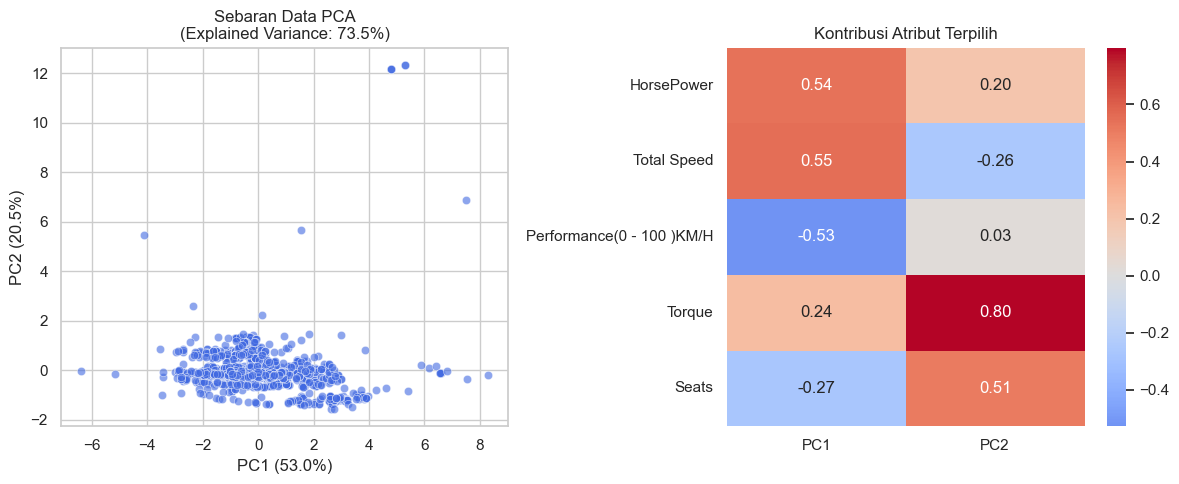

In [6]:
# Plot Sebaran Data PCA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.6, color='royalblue')
plt.title(f'Sebaran Data PCA\n(Explained Variance: {sum(pca_final.explained_variance_ratio_)*100:.1f}%)')
plt.xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True)

# Plot Heatmap Loadings (Kontribusi Atribut)
plt.subplot(1, 2, 2)
loadings_final = pd.DataFrame(pca_final.components_.T, columns=['PC1', 'PC2'], index=selected_features)
sns.heatmap(loadings_final, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Kontribusi Atribut Terpilih')

plt.tight_layout()
plt.show()

# Elbow Method

✅ K Optimal ditemukan secara otomatis: 4


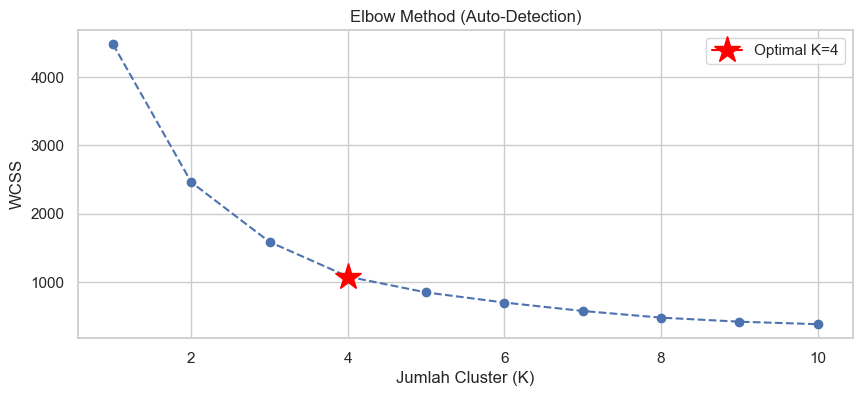

In [7]:
from sklearn.cluster import KMeans
import math

# 1. Hitung WCSS (Within-Cluster Sum of Squares)
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# 2. LOGIKA OTOMATIS: Jarak Terjauh dari Garis Diagonal
p1_x, p1_y = 1, wcss[0]       # Titik Awal
p2_x, p2_y = 10, wcss[-1]     # Titik Akhir

distances = []
for i in range(len(wcss)):
    p0_x = i + 1
    p0_y = wcss[i]
    # Rumus jarak titik ke garis
    numerator = abs((p2_y - p1_y) * p0_x - (p2_x - p1_x) * p0_y + p2_x * p1_y - p2_y * p1_x)
    denominator = math.sqrt((p2_y - p1_y)**2 + (p2_x - p1_x)**2)
    distances.append(numerator / denominator)

# K optimal = index jarak terbesar + 1
k_optimal = distances.index(max(distances)) + 1
print(f"✅ K Optimal ditemukan secara otomatis: {k_optimal}")

# 3. Plot Elbow
plt.figure(figsize=(10, 4))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.plot(k_optimal, wcss[k_optimal-1], marker='*', color='red', markersize=20, label=f'Optimal K={k_optimal}')
plt.title('Elbow Method (Auto-Detection)')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)
plt.show()

# K Means

In [9]:
import time

start_time = time.time()

# Eksekusi K-Means Final
kmeans_final = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_pca)

# --- SIMPAN HASIL ---
# 1. Ke DataFrame PCA (untuk plotting)
pca_df['Cluster'] = clusters

# 2. Ke DataFrame Bersih (untuk profiling statistik)
df_clean['Cluster_Label'] = clusters

# 3. Ke DataFrame Asli (untuk hasil export)
df['Cluster_Label'] = clusters

print(f"Clustering Selesai dalam {time.time() - start_time:.4f} detik.")
print(f"   Data dikelompokkan menjadi {k_optimal} cluster.")

Clustering Selesai dalam 0.0774 detik.
   Data dikelompokkan menjadi 4 cluster.


📊 Silhouette Score: 0.4094 (Range -1 s/d 1, semakin dekat 1 semakin baik)


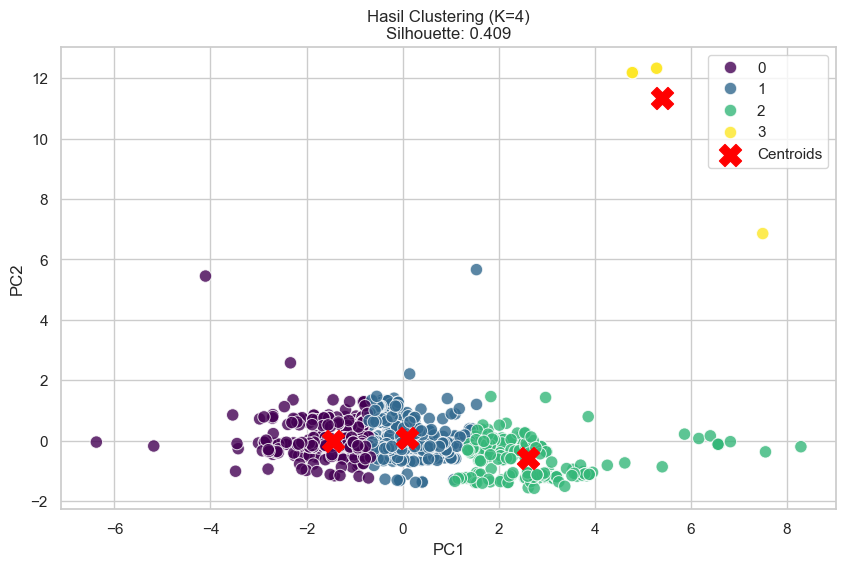

In [10]:
from sklearn.metrics import silhouette_score

# Hitung Silhouette Score
score = silhouette_score(X_pca, clusters)
print(f"📊 Silhouette Score: {score:.4f} (Range -1 s/d 1, semakin dekat 1 semakin baik)")

# Visualisasi Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=80, alpha=0.8)
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1], 
            s=250, c='red', marker='X', label='Centroids')

plt.title(f'Hasil Clustering (K={k_optimal})\nSilhouette: {score:.3f}')
plt.legend()
plt.grid(True)
plt.show()